## Let's use sigpy

In [9]:
import fastmri
from fastmri.data.subsample import EquispacedMaskFractionFunc, create_mask_for_mask_type
from fastmri.data import transforms as T
from sigpy.mri.app import EspiritCalib as Espirit
import numpy as np
import sigpy as sp
import h5py as h5
import matplotlib.pyplot as plt

 Args:
 
        * ksp (array): k-space array of shape [num_coils, n_ndim, ..., n_1]

        * calib (tuple of ints): length-2 image shape.

        * thresh (float): threshold for the calibration matrix.

        * kernel_width (int): kernel width for the calibration matrix.

        * max_power_iter (int): maximum number of power iterations.

        * device (Device): computing device.
        
        * crop (int): cropping threshold.


In [10]:
def save(ground_truth: np.ndarray, csm: np.ndarray, mask: np.ndarray, name: str, mode = 'train'):
    with h5.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
            # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
            if mode == 'train':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('trnCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('trnMask', data = mask)   # is the undersampling mask 
                target.create_dataset('trnOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth
            elif mode == 'test':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('tstCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('tstMask', data = mask)   # is the undersampling mask 
                target.create_dataset('tstOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth

In [40]:
# from numba import jit # DOES NOT WORK
# @jit  
# def extract_data_brain_numba(
#                 ground_truth,
#                 volume_kspace,
#                 orgFilename,
#                 center_fractions = [0.08 ],
#                 accelerations = [2],# 4
#                 ):
#     csm = []
    
#     mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
#     masks = []


#     for slice_kspace in volume_kspace:
        
#         # ESPIRiT:
#         #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
#         c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
#         csm.append(c1)
#         # Extract Masks
#         slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
#         _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
#         tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
#         tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
#         masks.append(tiled_mask)#mask.numpy())
    
#     csm = np.array(csm)
#     masks = np.asarray(masks)  
#     name = 'csm_'+orgFilename
#     save(ground_truth, csm, masks, name)
    

In [27]:
def extract_data_brain(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               )-> None:
    path_to_data = '/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_train/'
    with h5.File(path_to_data + orgFilename, 'r') as f:
        ground_truth = f['reconstruction_rss'][()]
        volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    csm = []
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    masks = []
    for slice_kspace in volume_kspace:
        # ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)
        # Extract Masks
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
        masks.append(tiled_mask) #mask.numpy())
    
    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    save(ground_truth, csm, masks, name)
        

In [51]:
orgFilename = 'file_brain_AXFLAIR_201_6002902.h5'

In [42]:
extract_data_brain(orgFilename)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

<HDF5 dataset "trnCsm": shape (14, 20, 640, 320), type "<c8">


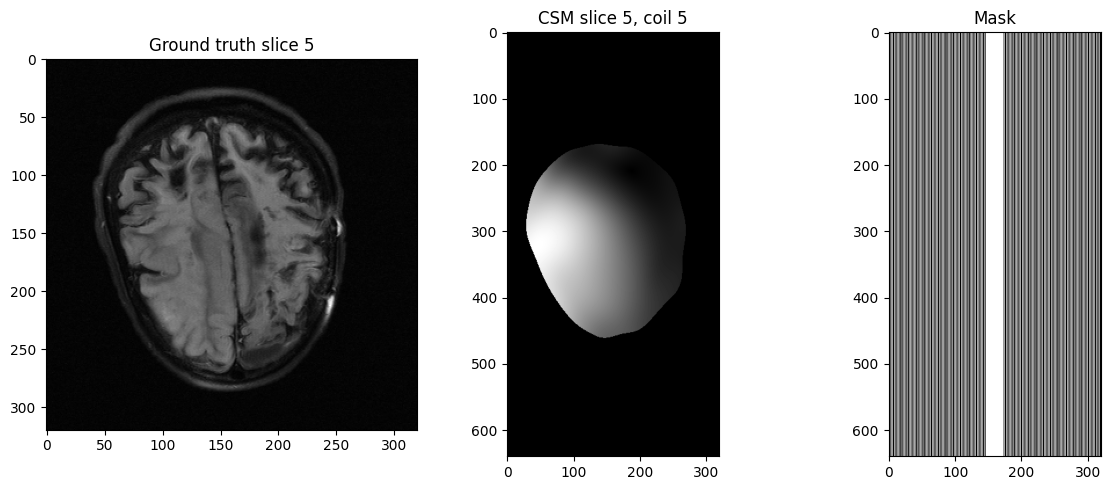

In [52]:
hf = h5.File('csm_' + orgFilename, 'r')
print(hf['trnCsm'])

slice = 5
coil = 5


plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(np.abs(hf['trnOrg'][slice]), cmap="gray"); plt.title(f'Ground truth slice {slice}')
plt.subplot(1,3,2); plt.imshow(np.abs(hf['trnCsm'][slice][coil]), cmap="gray"); plt.title(f'CSM slice {slice}, coil {coil}')
plt.subplot(1,3,3); plt.imshow(np.abs(hf['trnMask'][slice]), cmap="gray"); plt.title(f'Mask')

plt.tight_layout() 

In [56]:
AAAA = np.concatenate((hf['trnOrg'][()], hf['trnOrg'][()]))
AAAA.shape

(28, 320, 320)

In [43]:
def extract_data_brain_test(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               ):
    path_to_data = '/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_test/'
    f = h5.File(path_to_data + orgFilename, 'r')
    ground_truth = f['reconstruction_rss'][()]
    volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    csm = []
    
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    masks = []


    for slice_kspace in volume_kspace:
        
        # ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)
        # Extract Masks
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
        masks.append(tiled_mask)#mask.numpy())
    
    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    save(ground_truth, csm, masks, name, mode = "test")

In [ ]:
testFile = 'file_brain_AXFLAIR_201_6002868.h5'
extract_data_brain_test(testFile)

## Bringing all together

In [62]:
import os
# Import Pillow and resize ... 
def mergeFiles(target_name:str, directory_train:str = 'trn', directory_test:str = 'tst'):
    with h5.File(target_name, 'w') as target:
        trncsms = None
        trnmasks = None
        trnorgs = None
        tstcsms = None
        tstmasks = None
        tstorgs = None
        for filename in os.scandir(directory_train):
            if filename.is_file():
                with h5.File(filename) as f:
                    if trncsms is None: # or masks or org
                        trncsms = f['trnOrg'][()]
                        trnmasks = f['trnMask'][()]
                        trnorgs = f['trnOrg'][()]
                    else: 
                        trncsms = np.concatenate((trncsms, f['trnOrg'][()]))
                        trnmasks = np.concatenate((trnmasks, f['trnMask'][()])) 
                        trnorgs =  np.concatenate((trnorgs, f['trnOrg'][()])) 

        for filename in os.scandir(directory_test):
            if filename.is_file():
                with h5.File(filename) as f:
                    if trncsms is None: # or masks or org
                        tstcsms = f['tstOrg'][()]
                        tstmasks = f['tstMask'][()]
                        tstorgs = f['tstOrg'][()]
                    else: 
                        tstcsms = np.concatenate((tstcsms, f['tstOrg'][()]))
                        tstmasks = np.concatenate((tstmasks, f['tstMask'][()])) 
                        tstorgs =  np.concatenate((tstorgs, f['tstOrg'][()])) 
        target.create_dataset('trnCsm', data = trncsms)    # saves the coil sensitivity maps
        target.create_dataset('trnMask', data = trnmasks)   # is the undersampling mask 
        target.create_dataset('trnOrg', data = trnorgs)  # this is the original ground truth
        target.create_dataset('tstCsm', data = tstcsms)    # saves the coil sensitivity maps
        target.create_dataset('tstMask', data = tstmasks)   # is the undersampling mask 
        target.create_dataset('tstOrg', data = tstorgs) # this is the original ground truth

In [ ]:
target_name = 'datasetCIP.h5'
mergeFiles(target_name) 

with h5.File('target_name') as DataModl:
    print(DataModl.keys())
    print(DataModl['tstCsm'])
    print(DataModl['trnMask'])
    print(DataModl['trnOrg'])
    

In [ ]:
plt.subplot(1,3,1); plt.imshow(np.abs(hf['trnOrg'][slice]), cmap="gray"); plt.title(f'Ground truth slice {slice}')
plt.subplot(1,3,2); plt.imshow(np.abs(hf['trnCsm'][slice][coil]), cmap="gray"); plt.title(f'CSM slice {slice}, coil {coil}')
plt.subplot(1,3,3); plt.imshow(np.abs(hf['trnMask'][slice]), cmap="gray"); plt.title(f'Mask')

# For Knee

In [ ]:
def saveKnee(ground_truth: np.ndarray, csm: np.ndarray, mask: np.ndarray, atb: np.ndarray, name: str):
    with h5.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
        # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
        target.create_dataset('atb', data = atb)    # is the aliased/noisy image # It is not necessary for Brain_data
        target.create_dataset('csm', data = csm)    # saves the coil sensitivity maps
        target.create_dataset('mask', data = mask)   # is the undersampling mask 
        target.create_dataset('org', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth

In [ ]:
def extract_data_knee(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               ):
    path_to_data = '/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_train/'
    f = h5.File(path_to_data + orgFilename, 'r')
    ground_truth = f['reconstruction_rss'][()]
    volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    #volume_kspace = np.swapaxes(volume_kspace, 0,1) # uncomment if needed

    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)

    atbs = []
    atbs_before = []
    masks = []
    csm = []

    for slice_kspace in volume_kspace:
        #ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)

        # Aliased/Noisy Image (ATB)
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        

        masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        
        # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = mask[0,:,:,0]
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))


        sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image


        ## we need complex values -> real and imaginary parts are stored separately...
        sampled_image_complex = sampled_image[:,:,:,0]+1j*sampled_image[:,:,:,1]
        

        ## Apply Root-Sum-of-Squares (RSS) transform.
        sampled_image_rss = fastmri.rss(sampled_image_complex, dim = 0)
        sampled_image_rss_2 = fastmri.rss(np.abs(sampled_image_complex), dim = 0)  # Compute absolute value to get a real image

        ##* Note:  with sampled_image_rss_2 we obtain the same result as with : 
        #sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
        #sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
        

        #sampled_image_rss = np.abs(sampled_image_rss)
        atbs_before.append(sampled_image_rss_2.numpy())
        atbs.append(sampled_image_rss.numpy())
        masks.append(tiled_mask)#mask.numpy())

    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    saveKnee(ground_truth, csm, masks, name)